In [1]:
import numpy as np
import random

import gym
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, MultivariateNormal

import torch.optim as optim
import time
from torch.utils.tensorboard import SummaryWriter
import argparse
from copy import deepcopy
from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams.update({'axes.labelsize':16, 'xtick.labelsize':13, 'ytick.labelsize':13, 'legend.fontsize':14, 'legend.title_fontsize':14, 
                     'figure.titlesize':16, 'axes.titlesize': 14})

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
def plot(frame_idx, scores, save_pic=False):
    clear_output(True)
    plt.figure(figsize=(24, 5))
   
    mean_score = 0
    colors = ['b', 'm', 'c', 'g', 'y']
    for i, sc in enumerate(scores):
        mean_score += np.mean(scores[sc][-20:])
        plt.plot(np.linspace(1, frame_idx, len(scores[sc])), scores[sc], colors[i], linewidth=1, label=sc)   
    plt.title(f"frame {frame_idx}. score: {mean_score:.2f}")
    plt.axhline(y=0.0, color='grey', linestyle='--')
    plt.legend()
    if save_pic:
        plt.savefig(f'results_eps-{frame_idx}_{(time.asctime()[4:16].replace(":","-"))}.png')
    plt.show()
    
def dic_builder(num_walkers, value):
    return {f'walker_{n}':deepcopy(value) for n in range(num_walkers)}

In [3]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, hidden_size=32, init_w=3e-3, log_std_min=-20, log_std_max=2):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        self.hidden_size = hidden_size
        self.batch_size = BATCHES
        self.rnn_layers = 2
        
#         self.fc1 = nn.Linear(state_size, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.rnn = nn.GRU(state_size, hidden_size, self.rnn_layers, batch_first=True)
        
        self.mu = nn.Linear(hidden_size, action_size)
        self.log_std_linear = nn.Linear(hidden_size, action_size)
        
        self.init_state()


    def reset_parameters(self):
#         self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
#         self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.rnn.weight.data.uniform_(*hidden_init(self.rnn))
        self.mu.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)

    def forward(self, state):

#         x = F.relu(self.fc1(state), inplace=True)
        x, self.h0 = self.rnn(state, self.h0)
#         x = F.relu(self.fc2(x), inplace=True)

        mu = self.mu(x)

        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        return mu[0], log_std[0]
    
    def evaluate(self, state, epsilon=1e-6):

        mu, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(0, 1)
        e = dist.sample().to(device)
        action = torch.tanh(mu + e * std)
        log_prob = Normal(mu, std).log_prob(mu + e * std) - torch.log(1 - action.pow(2) + epsilon)

        return action, log_prob
        
    
    def get_action(self, state):
        """
        returns the action based on a squashed gaussian policy. That means the samples are obtained according to:
        a(s,e)= tanh(mu(s)+sigma(s)+e)
        """
        #state = torch.FloatTensor(state).to(device) #.unsqzeeze(0)
        mu, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(0, 1)
        e      = dist.sample().to(device)
        action = torch.tanh(mu + e * std).cpu()
        #action = torch.clamp(action*action_high, action_low, action_high)
        return action[0]
    
    def init_state(self, batch_size=0):
        if batch_size == 0:
            batch_size = self.batch_size 
            
        self.h0 = torch.zeros(self.rnn_layers, batch_size, self.hidden_size).to(device)

In [4]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, hidden_size=32):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            hidden_size (int): Number of nodes in the network layers
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.hidden_size = hidden_size
        self.batch_size = BATCHES
        self.fc1 = nn.Linear(state_size+action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.rnn = nn.GRU(state_size+action_size, hidden_size, 2, batch_first=True)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.reset_parameters()
        self.init_state()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
#         self.rnn.weight.data.uniform_(*hidden_init(self.rnn))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = torch.cat((state, action), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         x = self.rnn(x)
        x = self.fc3(x)
        return x.squeeze(0)
    
    def init_state(self, batch_size=0):
        if batch_size == 0:
            batch_size = self.batch_size
        else: 
            batch_size = 1
        self.h0 = torch.zeros(1, batch_size, self.hidden_size).to(device)

In [5]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, name, state_size, action_size, random_seed, hidden_size, action_prior="uniform"):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.name = name
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        
        self.target_entropy = -action_size  # -dim(A)
        self.alpha = 1
        self.log_alpha = torch.tensor([0.0], requires_grad=True)
        self.alpha_optimizer = optim.Adam(params=[self.log_alpha], lr=LR_ACTOR) 
        self._action_prior = action_prior
        
        print("Using: ", device)
        
        # Actor Network 
        self.actor_local = Actor(state_size, action_size, random_seed, hidden_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)  
        
        # Critic Network (w/ Target Network)
        self.critic1 = Critic(state_size, action_size, random_seed, hidden_size).to(device)
        self.critic2 = Critic(state_size, action_size, random_seed, hidden_size).to(device)
        
        self.critic1_target = Critic(state_size, action_size, random_seed,hidden_size).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())

        self.critic2_target = Critic(state_size, action_size, random_seed,hidden_size).to(device)
        self.critic2_target.load_state_dict(self.critic2.state_dict())

        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=LR_CRITIC, weight_decay=0)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=LR_CRITIC, weight_decay=0) 

        # Replay memory
        self.memory = ReplayBuffer(action_size, BATCHES, GAMES_MEMORY, random_seed)
        

    def step(self, state, action, reward, next_state, done, step):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

            
    
    def act(self, state):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        action = self.actor_local.get_action(state).detach()
        return action

    def learn(self):
        """Updates actor, critics and entropy_alpha parameters using given batch of experience tuples.
        Q_targets = r + γ * (min_critic_target(next_state, actor_target(next_state)) - α *log_pi(next_action|next_state))
        Critic_loss = MSE(Q, Q_target)
        Actor_loss = α * log_pi(a|s) - Q(s,a)
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """   
        gamma = GAMMA
        
        for experience in self.memory.sample():
            states, actions, rewards, next_states, dones = experience
            
            for ep in range(EPOCHS):

                self.actor_local.init_state(states.shape[0])
                # ---------------------------- update critic ---------------------------- #

                # Get predicted next-state actions and Q values from target models
                next_action, log_pis_next = self.actor_local.evaluate(next_states)
    #             print(f'{}')
                Q_target1_next = self.critic1_target(np.squeeze(next_states, axis=0).to(device), next_action.to(device))
                Q_target2_next = self.critic2_target(np.squeeze(next_states, axis=0).to(device), next_action.to(device))

                # take the mean of both critics for updating
                Q_target_next = torch.min(Q_target1_next, Q_target2_next)

                for i in range(len(Q_target_next)-1, 1, -1):
                    Q_target_next[i-1, 0] += Q_target_next[i, 0] * 0.99

                if FIXED_ALPHA == None:
                    # Compute Q targets for current states (y_i)
                    Q_targets = rewards.cpu() + (gamma * (1 - dones.cpu()) * (Q_target_next.cpu() - self.alpha * log_pis_next.squeeze(1).cpu()))
                else:
                    Q_targets = rewards.cpu() + (gamma * (1 - dones.cpu()) * (Q_target_next.cpu() - FIXED_ALPHA * log_pis_next.squeeze(1).cpu()))
                # Compute critic loss
                print(f'{states.shape = }')
                print(f'{actions.shape = }')
                Q_1 = self.critic1(states.squeeze(0), actions).cpu()
                Q_2 = self.critic2(states.squeeze(0), actions).cpu()

                critic1_loss = 0.5*F.mse_loss(Q_1, Q_targets.detach().mean(1, keepdim=True))
                critic2_loss = 0.5*F.mse_loss(Q_2, Q_targets.detach().mean(1, keepdim=True))
                # Update critics
                # critic 1
                self.critic1_optimizer.zero_grad()
                critic1_loss.backward()
                self.critic1_optimizer.step()
                # critic 2
                self.critic2_optimizer.zero_grad()
                critic2_loss.backward()
                self.critic2_optimizer.step()

                # ---------------------------- update actor ---------------------------- #
                if FIXED_ALPHA == None:
                    alpha = torch.exp(self.log_alpha)
                    # Compute alpha loss
                    actions_pred, log_pis = self.actor_local.evaluate(states)
                    alpha_loss = - (self.log_alpha.cpu() * (log_pis.cpu() + self.target_entropy).detach().cpu()).mean()
                    self.alpha_optimizer.zero_grad()
                    alpha_loss.backward()
                    self.alpha_optimizer.step()

                    self.alpha = alpha
                    # Compute actor loss
                    if self._action_prior == "normal":
                        policy_prior = MultivariateNormal(loc=torch.zeros(self.action_size), scale_tril=torch.ones(self.action_size).unsqueeze(0))
                        policy_prior_log_probs = policy_prior.log_prob(actions_pred)
                    elif self._action_prior == "uniform":
                        policy_prior_log_probs = 0.0

                    actor_loss = (alpha * log_pis.squeeze(0).cpu() - self.critic1(np.squeeze(states, axis=0), actions_pred).cpu() - policy_prior_log_probs ).mean()
                else:

                    actions_pred, log_pis = self.actor_local.evaluate(states)
                    if self._action_prior == "normal":
                        policy_prior = MultivariateNormal(loc=torch.zeros(self.action_size), scale_tril=torch.ones(self.action_size).unsqueeze(0))
                        policy_prior_log_probs = policy_prior.log_prob(actions_pred)
                    elif self._action_prior == "uniform":
                        policy_prior_log_probs = 0.0

                    actor_loss = (FIXED_ALPHA * log_pis.squeeze(0).cpu() - self.critic1(states, actions_pred.squeeze(0)).cpu()- policy_prior_log_probs ).mean()
                # Minimize the loss
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                # observation [24:] -> 0
    #             self.actor_local.rnn.weight.grad[:, 24:] = 0

                #Gradient Value Clipping
                nn.utils.clip_grad_value_(self.actor_local.parameters(), clip_value=1.0)

                self.actor_optimizer.step()

                # ----------------------- update target networks ----------------------- #
                self.soft_update(self.critic1, self.critic1_target, TAU)
                self.soft_update(self.critic2, self.critic2_target, TAU)
            
                     
    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
    def zero_state(self, batch_size=0):
        self.actor_local.init_state(batch_size)
        self.critic1.init_state(batch_size)
        self.critic2.init_state(batch_size)
        self.critic1_target.init_state(batch_size)
        self.critic2_target.init_state(batch_size)
        
    def save_model(self, text=''):
        if len(text) > 0:
            text = '_'+text
        torch.save(self.actor_local.state_dict(), self.name + text+".pt")
        torch.save(self.critic1.state_dict(), self.name + text+"_critic1.pt")
        torch.save(self.critic2.state_dict(), self.name + text+"_critic2.pt")
        print('\tmodel saved', self.name + text+".pt")
    
    def load_model(self, file_name=''):
        if len(file_name) < 1:
            file_name = self.name + "_last.pt"
            file_name_cr1 = self.name + "_last_critic1.pt"
            file_name_cr2 = self.name + "_last_critic2.pt"
        else:
            file_name_cr1 = file_name[:-3]+"_critic1"+'.pt'
            file_name_cr2 = file_name[:-3]+"_critic2"+'.pt'
            
        self.actor_local.load_state_dict(torch.load(file_name))
        self.critic1.load_state_dict(torch.load(file_name_cr1))
        self.critic2.load_state_dict(torch.load(file_name_cr2))
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target.load_state_dict(self.critic2.state_dict())
        print('\tmodel loaded', file_name)

In [6]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, batches, games_memory, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.games_in_memory = 1
        self.cur_game = 0
        self.games_memory = games_memory
        self.action_size = action_size
        self.memory = [deque() for _ in range(games_memory)] # internal memory (deque)
        self.batches = batches
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.prob = []
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory[self.cur_game].append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        batches = min(self.batches, self.games_in_memory)
        rand_games = random.sample(range(self.games_in_memory), k=batches)
        pos_rand_games = len(rand_games) - 1
        while pos_rand_games > -1:
            experiences = self.memory[rand_games[pos_rand_games]]
        
            states = torch.from_numpy(np.concatenate([e.state for e in experiences if e is not None], axis=1)).float().to(device)
            actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
            rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
            next_states = torch.from_numpy(np.concatenate([e.next_state for e in experiences if e is not None], axis=1)).float().to(device)
            dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
            yield (states, actions, rewards, next_states, dones)
            pos_rand_games -= 1
            

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
    def next_game(self):
        self.cur_game = (self.cur_game + 1) % self.games_memory
        self.games_in_memory = (self.games_in_memory + 1) % self.games_memory

In [7]:
def SAC(n_episodes=200, max_t=500, print_every=10):
    agent.actor_local.train()
    scores_deque = deque(maxlen=50)
    average_100_scores = []
    best_score = BEST_SCORE

    for i_episode in range(1, n_episodes+1):
        agent.zero_state(1)
        
        state = np.zeros((1,1,31))
        next_state = np.zeros((1,1,31))
        state[0,0,:24] = env.reset()
        score = 0
        for t in range(max_t):
            
            action = agent.act(state)
            action_v = action.numpy()
            action_v = np.clip(action_v*action_high, action_low, action_high)
            next_state[0,0,:24], reward, done, info = env.step(action_v)
            agent.step(state, action, reward, next_state, done, t)
            state = deepcopy(next_state)
            score += reward

            if done:
                break 
                
        agent.learn()
        agent.memory.next_game()
        
        scores_deque.append(score)
        average_100_scores.append(np.mean(scores_deque))
        if round(average_100_scores[-1]/10) > round(best_score/10):
            best_score = average_100_scores[-1]
            agent.save_model('Best_'+str(round(best_score)))
        
        print('\rEpisode {} Reward: {:.2f}  Average 50 Score: {:.2f} best: {:.2f}'.format(i_episode, score, np.mean(scores_deque), best_score), 
              ' '*10, end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}  Reward: {:.2f}\tAverage 50 Score: {:.2f} best: {:.2f}'.format(i_episode, score, np.mean(scores_deque), best_score), 
                  ' '*10)
    if SAVE_MODEL:
        agent.save_model('last')
        
    return average_100_scores

In [8]:
def play(max_t=1000, test=False, save_video=False):
    agent.actor_local.eval()
    if save_video:
        from gym.wrappers import Monitor
        env = Monitor(gym.make(env_name), './video', force=True)
    else:
        env = gym.make(env_name)
    agent.actor_local.eval()
    for i_episode in range(1):
        agent.zero_state(1)

        state = np.zeros((1,1,31))
        next_state = np.zeros((1,1,31))
        state[0,0,:24] = env.reset()

        for t in range(max_t):
            if test:
                env.render()
            action = agent.act(state)
            action_v = action.numpy()
            action_v = np.clip(action_v*action_high, action_low, action_high)
            next_state[0,0,:24], reward, done, info = env.step(action_v)
#             agent.step(state, action, reward, next_state, done, t)
            state = deepcopy(next_state)

            if done:
                break 
    env.close()

In [9]:
SEED = 0
PRINT_EVERY = 100
BEST_SCORE = 30
GAMMA = 0.99
TAU = 1e-2
HIDDEN_SIZE = 128
GAMES_MEMORY = 500
BATCHES = 50
LR_ACTOR = 4e-4
LR_CRITIC = 4e-4
FIXED_ALPHA = None #"entropy alpha value, if not choosen the value is leaned by the agent"
EPOCHS = 3

N_EPOCHS = 2
# env_name = "BipedalWalkerHardcore-v3"
env_name = "BipedalWalker-v3"
saved_model = 'Walker_RNN2_last.pt' #"Load a saved model to perform a test run!"

In [11]:

LOAD_MODEL = True
SAVE_MODEL = True

if __name__ == "__main__":
    t0 = time.time()
    env = gym.make(env_name)
    action_high = env.action_space.high[0]
    action_low = env.action_space.low[0]
    torch.manual_seed(SEED)
    env.seed(SEED)
    np.random.seed(SEED)
    state_size = 31  # for multiwalker
    action_size = env.action_space.shape[0]
    agent = Agent(name='Walker_RNN2', state_size=state_size, action_size=action_size, random_seed=SEED,hidden_size=HIDDEN_SIZE, 
                  action_prior="uniform") #"normal"
    if LOAD_MODEL:
        agent.load_model(saved_model)

Using:  cuda:0


RuntimeError: Error(s) in loading state_dict for Actor:
	Missing key(s) in state_dict: "rnn.weight_ih_l1", "rnn.weight_hh_l1", "rnn.bias_ih_l1", "rnn.bias_hh_l1". 
	Unexpected key(s) in state_dict: "fc2.weight", "fc2.bias". 

In [14]:
print(agent.actor_local)

Actor(
  (rnn): GRU(31, 128, num_layers=2, batch_first=True)
  (mu): Linear(in_features=128, out_features=4, bias=True)
  (log_std_linear): Linear(in_features=128, out_features=4, bias=True)
)


In [16]:
from torchinfo import summary 

In [29]:
_=summary(agent.actor_local, input_size=(1,1,31), col_names=["input_size","output_size","num_params"], verbose=2)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Actor                                    --                        --                        --
├─GRU: 1-1                               [1, 1, 31]                [1, 1, 128]               160,896
│    └─weight_ih_l0                                                                          ├─11,904
│    └─weight_hh_l0                                                                          ├─49,152
│    └─bias_ih_l0                                                                            ├─384
│    └─bias_hh_l0                                                                            ├─384
│    └─weight_ih_l1                                                                          ├─49,152
│    └─weight_hh_l1                                                                          ├─49,152
│    └─bias_ih_l1                                                                            ├─3

In [11]:
train = False
if train:
    SAC(n_episodes=N_EPOCHS, max_t=300, print_every=PRINT_EVERY)
else:
    play(1000, True, False)

t1 = time.time()
env.close()
print("\ntraining took {} min!".format((t1-t0)/60))

Using:  cuda:0


RuntimeError: Error(s) in loading state_dict for Actor:
	Missing key(s) in state_dict: "rnn.weight_ih_l1", "rnn.weight_hh_l1", "rnn.bias_ih_l1", "rnn.bias_hh_l1". 
	Unexpected key(s) in state_dict: "fc2.weight", "fc2.bias". 

In [35]:
# agent.load_model('Walker_RNN_Best_87.pt')
play(500, test=True, save_video=False)

In [1]:
!start .

In [3]:
rewards_txt = '''Episode 100  Reward: -111.76	Average 50 Score: -92.48 best: 0.00           
Episode 200  Reward: -11.85	Average 50 Score: -34.82 best: 0.00            
Episode 300  Reward: -11.34	Average 50 Score: -65.59 best: 0.00            
Episode 400  Reward: -117.84	Average 50 Score: -58.15 best: 0.00           
Episode 500  Reward: 11.54	Average 50 Score: -56.97 best: 0.00             
Episode 600  Reward: -7.36	Average 50 Score: -64.19 best: 0.00             
Episode 700  Reward: 21.89	Average 50 Score: -31.57 best: 0.00             
Episode 800  Reward: 2.54	Average 50 Score: -9.53 best: 0.00               
Episode 900  Reward: -76.11	Average 50 Score: -22.82 best: 0.00            
Episode 1000  Reward: 41.96	Average 50 Score: -16.32 best: 0.00            
Episode 1100  Reward: -50.25	Average 50 Score: -16.06 best: 36.79           
Episode 1200  Reward: -105.73	Average 50 Score: 0.34 best: 36.79             
Episode 1300  Reward: -68.56	Average 50 Score: -27.05 best: 36.79            
Episode 1400  Reward: 59.76	Average 50 Score: -6.00 best: 36.79              
Episode 1500  Reward: -78.99	Average 50 Score: 31.26 best: 43.11            
Episode 1600  Reward: 80.28	Average 50 Score: 40.63 best: 43.11             
Episode 1700  Reward: 55.59	Average 50 Score: 48.44 best: 74.08             
Episode 1800  Reward: 84.14	Average 50 Score: -6.85 best: 74.08             
Episode 1900  Reward: -99.95	Average 50 Score: 29.74 best: 74.08            
Episode 2000  Reward: 86.62	Average 50 Score: 53.91 best: 74.08'''

In [10]:
r_lines = rewards_txt.split('\n')

In [11]:
for r in range(len(r_lines)):
    r_lines[r] = float(r_lines[r].split('Score: ')[1].split(' best')[0])
r_lines

[-92.48,
 -34.82,
 -65.59,
 -58.15,
 -56.97,
 -64.19,
 -31.57,
 -9.53,
 -22.82,
 -16.32,
 -16.06,
 0.34,
 -27.05,
 -6.0,
 31.26,
 40.63,
 48.44,
 -6.85,
 29.74,
 53.91]

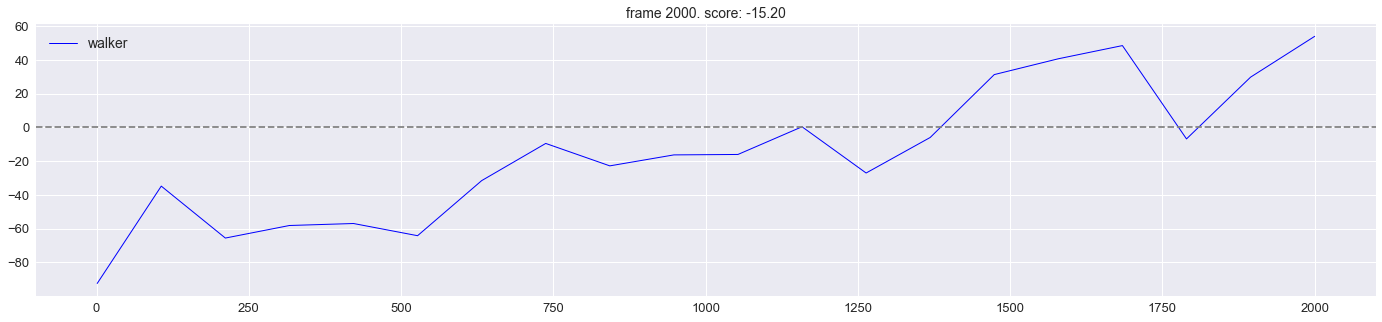

In [18]:
plot(2000, {'walker':r_lines})